In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import model_crommelin_seasonal
import feature_crommelin 
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import helper2

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

Create directories to save results 

In [7]:
# Organize the directory of data and features to be read from the data. 
topic_dir = "/scratch/jf4241/crommelin"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "reanalysis", "trajectory", "2022-07-28", "0"), # Directory with possibly many files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "reanalysis", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "reanalysis", "features_tpt", "2022-07-28", "0",),
                "filename": "crom_feat_tpt.nc",
            }),
        }),
        "hc": dict({
            "traj": dict({
                "dir": join(topic_dir, "hindcast", "trajectory", "2022-07-28", "0"), # Directory with possibly multiple files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "hindcast", "features_all", "2022-07-28", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "hindcast", "features_tpt", "2022-07-28", "0"),
                "filename": "crom_feat_tpt.nc",
            })
        }),        
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "2022-07-28", "0")
    })
})

In [8]:
# Create the directories if they don't exist already
for src in ["ra","hc"]:
    for fmt in ["traj","feat_all","feat_tpt"]:
        path = filedict["data"][src][fmt]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

Set physical parameters

In [9]:
dt_samp = 0.5 # Time step to save out
dt_szn = 0.74 # Time resolution for the seasonal model 
szn_start = 300.0
szn_length = 250.0
year_length = 400.0
Nt_szn = int(szn_length / dt_szn)
szn_avg_window = 5.0
burnin_time = 500.0

In [10]:
reload(model_crommelin_seasonal)

<module 'model_crommelin_seasonal' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/model_crommelin_seasonal.py'>

Initialize the model.

In [11]:
fundamental_param_dict = dict({
    "b": 0.5, "beta": 1.25, "gamma_limits": [0.15, 0.22], 
    "C": 0.1, "x1star": 0.95, "r": -0.801, "year_length": year_length,
})
crom = model_crommelin_seasonal.SeasonalCrommelinModel(fundamental_param_dict)


Create "reanalysis" in the file folder reserved for contiguous data.

In [12]:
# Run the model initially for a bit to find the attractor. Start arbitrarily 1/5 of the way through year 1958
t_init = (1957 + 0.2)*fundamental_param_dict["year_length"]
x0 = np.zeros((1,7))
x0[0,-1] = t_init
t_save = np.arange(0, burnin_time, dt_samp)
traj_filename_burnin = join(filedict["data"]["ra"]["traj"]["dir"], "burnin.nc")
crom.integrate_and_save(x0,t_save,traj_filename_burnin)

In [13]:
x_burnin = xr.open_dataset(traj_filename_burnin)["X"]
x0 = x_burnin[:,-1].data
duration = 200*fundamental_param_dict["year_length"]
t_init_str,_ = crom.date_format(x0[0,-1])
t_fin_str,_ = crom.date_format(x0[0,-1] + duration)
traj_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], f"ra_{t_init_str}_to_{t_fin_str}.nc")
param_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], "params")

In [14]:
t_save = np.arange(0,duration,dt_samp)
crom.integrate_and_save(x0,t_save,traj_filename_ra,metadata_filename=param_filename_ra)

Integrated through time 1000.0000000001588 out of 79999.5
Integrated through time 2000.0999999992764 out of 79999.5
Integrated through time 3000.099999998367 out of 79999.5
Integrated through time 4000.0999999974574 out of 79999.5
Integrated through time 5000.0000000006585 out of 79999.5
Integrated through time 6000.000000004296 out of 79999.5
Integrated through time 7000.000000007934 out of 79999.5
Integrated through time 8000.000000011572 out of 79999.5
Integrated through time 9000.00000001521 out of 79999.5
Integrated through time 10000.000000018848 out of 79999.5
Integrated through time 11000.000000022486 out of 79999.5
Integrated through time 12000.000000026124 out of 79999.5
Integrated through time 13000.000000029762 out of 79999.5
Integrated through time 14000.0000000334 out of 79999.5
Integrated through time 15000.000000037038 out of 79999.5
Integrated through time 16000.000000040676 out of 79999.5
Integrated through time 17000.00000003311 out of 79999.5
Integrated through time

Create "hindcast" data in the file folder reserved for hindcast data.

In [18]:
# Generate hindcast dataset
t_abs_range = crom.q["year_length"]*np.array([1960,1970])
crom.generate_hindcast_dataset(
    [traj_filename_ra],filedict["data"]["hc"]["traj"]["dir"],t_abs_range,dt_samp,
    ens_size=10,ens_duration=47,ens_gap=13,pert_scale=0.01
)

Hindcast integration 25.312499987662886 percent done
Hindcast integration 50.28749998184794 percent done
Hindcast integration 75.262499976033 percent done
Hindcast integration 100.23749997021805 percent done


Extract features of interest from both the reanalysis and hindcast datasets. This will be expensive, as we have to read from a large database of files. Therefore, we should minimize the number of times we do this in development. Therefore, we should read in ALL possible features we MIGHT use for the downstream tasks of K-means clustering. Some extra reduction is likely necessary.

# All possible features for DGA

In [19]:
reload(feature_crommelin)

<module 'feature_crommelin' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/feature_crommelin.py'>

In [20]:
# Extract all features of potential use from the reanalysis dataset. 
# Don't waste RAM by time-delay embedding explicitly
# Encode this in a function that loops through all files in a directory and puts features into one file
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
qra = pickle.load(open(param_filename_ra,"rb"))

In [21]:
epd = dict(
    dt_szn = 0.74,
    szn_start = 300.0,
    szn_length = 250.0,
    year_length = 400.0,
    szn_avg_window = 5.0,
)
epd["Nt_szn"] = int(epd["szn_length"] / epd["dt_szn"])
crom_feat.set_event_params(epd)

In [22]:
# WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
# For example, if the identity observable and energy observable both have a coordinate called "feature", 
# then xarray will assume it's the same and smush them together, filling in NaNs. x
feat_all = dict()

In [23]:
for src in ["ra","hc"]:
    ds_feature_list = []
    file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if (f.startswith(src) and f.endswith(".nc"))]
    for filename in file_list:
        ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
        ds_feature_list += [
            xr.Dataset(
                data_vars = dict({
                    "identity": crom_feat.identity_observable(ds, qra),
                    "energy": crom_feat.energy_observable(ds, qra),
                    "energy_tendency": crom_feat.energy_tendency_observable(ds, qra),
                    "energy_exchange": crom_feat.energy_exchange_observable(ds, qra),
                    "phase": crom_feat.phase_observable(ds, qra),
                })
            )
        ]
        ds.close()
    feat_all[src] = xr.concat(ds_feature_list,dim="ensemble") # ensemble is a new dimension
    feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

# Subset observables for use in TPT analysis
Incorporate any time-delay information we might want. 

In [123]:
feat_all = dict()
feat_tpt = dict()
# List the features to put into feat_tpt
# First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
# over some time horizon. 
time_horizon = 40.0 # time units
feat_tpt_list = ([
    "t_abs","x1_runmean","x1_runmin","x1_runmax",
    "t_szn","szn_start_year","t_cal","ti_szn"
])
# Physical features
feat_tpt_list += ([
    "x1","x2","x3","x4","x5","x6",
    "E_01","E_02","E_11","E_12","E_tot",
    "Edot_dissipation","Edot_forcing",
    "Ex_11-diss", "Ex_12-diss", "Ex_11-02", "Ex_11-12",
    "ph_11","ph_12",
])
for src in ["ra","hc"]:
    feat_all[src] = xr.open_dataset(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))
    feat_tpt[src] = xr.Dataset(
        data_vars = {
            "X": xr.DataArray(               
                coords = {
                    "ensemble": feat_all[src].coords["ensemble"],
                    "member": feat_all[src].coords["member"],
                    "t_sim": feat_all[src].coords["t_sim"],
                    "feature": feat_tpt_list,
                },
                data = np.zeros((
                    feat_all[src]["ensemble"].size, feat_all[src]["member"].size, 
                    feat_all[src]["t_sim"].size, len(feat_tpt_list)
                )),
            )
        }
    )
    for id_coord in ["x1","x2","x3","x4","x5","x6"]:
        feat_tpt[src]["X"].loc[dict(feature=id_coord)] = (
            feat_all[src]["identity"].sel(feature=id_coord)
        )
    for e_coord in ["E_01","E_02","E_11","E_12","E_tot"]:
        feat_tpt[src]["X"].loc[dict(feature=e_coord)] = (
            feat_all[src]["energy"].sel(reservoir=e_coord.replace("_",""))
        )
    for ph_coord in ["ph_11","ph_12"]:
        feat_tpt[src]["X"].loc[dict(feature=ph_coord)] = (
            feat_all[src]["phase"].sel(wavenumber=ph_coord.replace("_",""))
        )
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-diss")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="dissipation"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_12-diss")] = (
        feat_all[src]["energy_exchange"].sel(source="E12",sink="dissipation"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-02")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="E02"))
    feat_tpt[src]["X"].loc[dict(feature="Ex_11-12")] = (
        feat_all[src]["energy_exchange"].sel(source="E11",sink="E12"))
    
    feat_tpt[src]["X"].loc[dict(feature="t_abs")] = feat_all[src]["identity"].sel(feature="t_abs")
    feat_tpt[src]["X"].loc[dict(feature="Edot_dissipation")] = feat_all[src]["energy_tendency"].sel(Eflow="dissipation")
    feat_tpt[src]["X"].loc[dict(feature="Edot_forcing")] = feat_all[src]["energy_tendency"].sel(Eflow="forcing")    
    # For the A- and B-defining feature of x1, take the running mean, minimum, and maximum of x1 over the time horizon
    dt_samp = (feat_all[src]["t_sim"][1] - feat_all[src]["t_sim"][0]).data # Assume uniform time sampling!
    num_delays = int(time_horizon/dt_samp) + 1
    rolling_x1 = feat_all[src]["identity"].sel(feature="x1").rolling(
        dim={"t_sim": num_delays}, min_periods=num_delays) 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmean")] = rolling_x1.mean() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmin")] = rolling_x1.min() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmax")] = rolling_x1.max() 
    # Compute the calendar time and other temporal metadata, as this defines the seasonality 
    szn_start_year,t_cal,t_szn,ti_szn = crom_feat.time_conversion_from_absolute(
        feat_all[src]["identity"].sel(feature="t_abs")
    )
    feat_tpt[src]["X"].loc[dict(feature="t_szn")] = t_szn # Time since the most recent season beginning
    feat_tpt[src]["X"].loc[dict(feature="szn_start_year")] = szn_start_year
    feat_tpt[src]["X"].loc[dict(feature="t_cal")] = t_cal
    feat_tpt[src]["X"].loc[dict(feature="ti_szn")] = ti_szn # Which window of the discretized season this sample belongs to
    # Save 
    feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

shapes: field = (160000,), weights = (160000,), features = (160000, 1)
grid_cell: 
min = 
[0]
max=[19]


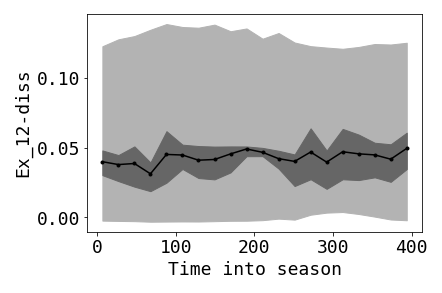

In [127]:
# Plot seasonal statistics of an observable
feat = "t_szn"
obs = "Ex_12-diss"
sel = dict(ensemble=0, member=0)
fig,ax = helper2.plot_field_1d(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature=obs).data.flatten(),
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).data.flatten(),
    feat_name="Time into season", field_name=obs
)

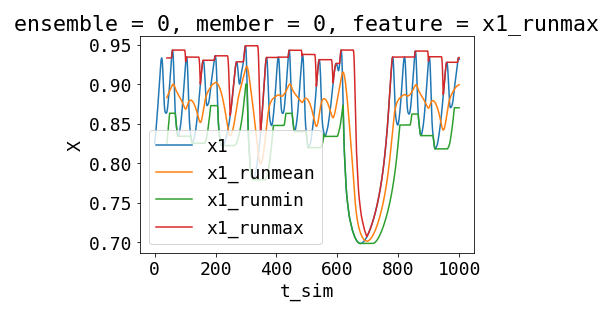

In [128]:
# Plot the running mean, min, and max of x1
fig,ax = plt.subplots()
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1"
)
h_x1_runmean, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmean",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmean"
)
h_x1_runmin, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmin",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmin"
)
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmax",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmax"
)
ax.legend(handles=[h_x1,h_x1_runmean,h_x1_runmin,h_x1_runmax])

# Defining A and B
First we make methods for computing the hitting times and destinations (both in forward and backward time) for two sets A and B, as well as their complement D. Each method will have an additional argument, "tpt_bndy", a dictionary of parameters (e.g., thresholds) that specify A and B. This will allow us to consider a whole parameterized family of A and B later on.

First: a function to assign each data point to A, B, or D.

In [129]:
abcode = {"A": 0, "B": 1, "D": 2}
def abtest(Xtpt, tpt_bndy):
    # Given a snapshot of an instance of the feat_tpt data structure, return ab_tag: 
    # 0 means in A, 1 means in B, and 2 means neither.
    # The definition of A and B will be parameterized by a dictionary, tpt_bndy, which specifies
    # the time of season when blockings can happen as well as the thresholds for A and B. 
    time_window_flag = 1.0*(
        Xtpt.sel(feature="t_szn") >= tpt_bndy["tthresh"][0])*(
        Xtpt.sel(feature="t_szn") <= tpt_bndy["tthresh"][1]
    )
    blocked_flag = 1.0*(Xtpt.sel(feature="x1_runmax") <= tpt_bndy["x1thresh"][0])
    zonal_flag = 1.0*(Xtpt.sel(feature="x1") >= tpt_bndy["x1thresh"][1])
    ab_tag = (
        abcode["A"]*((1*(time_window_flag == 0) + 1*zonal_flag) > 0) + 
        abcode["B"]*(time_window_flag*blocked_flag) + 
        abcode["D"]*(time_window_flag*(blocked_flag==0)*(zonal_flag==0))
    )
    return ab_tag

Second: compute hitting times. The optimal way to do this depends on whether we have a small number of long trajectories (as in reanalysis), or a large number of short trajectories (as in hindcasts). The functions are named "Cotton Eye Joe", a reference to the American folk song with the famous lyric "where did you come from, where did you go?"

In [130]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe_timesteps(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    # Forward pass through time 
    for i_time in np.arange(sintil["t_sim"].size):    
        if i_time % 200 == 0:
            print(f"Forward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:            
            if i_time > 0:
                sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                    sintil.isel(t_sim=i_time-1).sel(sense="since",state=state).data + 
                    sintil["t_sim"][i_time].data - sintil["t_sim"][i_time-1].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            # Wherever the state is achieved at this time slice, set the time since to zero
            sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="since",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="since",state=state))
            )
    # Backward pass through time
    for i_time in np.arange(sintil["t_sim"].size-1,-1,-1):
        if i_time % 200 == 0:
            print(f"Backward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:
            if i_time < sintil["t_sim"].size-1:
                sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                    sintil.isel(t_sim=i_time+1).sel(sense="until",state=state).data + 
                    sintil["t_sim"][i_time+1].data - sintil["t_sim"][i_time].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="until",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="until",state=state))
            )
    return sintil   

In [131]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe_timechunks(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    t_sim = Xtpt["t_sim"].data
    print(f"t_sim.shape = {t_sim.shape}")
    Nt = t_sim.size
    # Forward pass through time 
    for ensemble in Xtpt.coords["ensemble"]:
        for member in Xtpt.coords["member"]:
            for state in ["A","B"]:
                indicator = (ab_tag.sel(ensemble=ensemble,member=member) == abcode[state]).data.astype(int)
                tsince = np.nan*np.ones(Nt)
                tuntil = np.nan*np.ones(Nt)
                # Fill in zeros inside the set
                tsince[indicator==1] = 0.0
                tuntil[indicator==1] = 0.0
                # Find the crossover points
                idx_exit = np.where(np.diff(indicator) == -1)[0] + 1 # First step outside of state
                idx_entry = np.where(np.diff(indicator) == 1)[0] + 1 # First entry to state
                # Take care of boundary cases
                if (not indicator[0]) and len(idx_entry) > 0:
                    tuntil[:idx_entry[0]] = t_sim[idx_entry[0]] - t_sim[:idx_entry[0]]
                    idx_entry = idx_entry[1:]
                if (not indicator[Nt-1]) and len(idx_exit) > 0:
                    tsince[idx_exit[-1]:] = t_sim[idx_exit[-1]:] - t_sim[idx_exit[-1]-1]
                    idx_exit = idx_exit[:-1]
                # Now the middle components: time intervals between exits and entries
                if len(idx_entry) > 0 and len(idx_exit) > 0:
                    for k in range(len(idx_exit)):
                        i0,i1 = idx_exit[k],idx_entry[k]
                        tsince[i0:i1] = t_sim[i0:i1] - t_sim[i0-1]
                        tuntil[i0:i1] = t_sim[i1] - t_sim[i0:i1]
                sintil.loc[dict(ensemble=ensemble,member=member,state=state,sense="since")] = tsince
                sintil.loc[dict(ensemble=ensemble,member=member,state=state,sense="until")] = tuntil
    return sintil   

In [132]:
def cotton_eye_joe(Xtpt, tpt_bndy, ab_tag, mode):
    if mode == "timechunks":
        return cotton_eye_joe_timechunks(Xtpt, tpt_bndy, ab_tag)
    elif mode == "timesteps": 
        return cotton_eye_joe_timesteps(Xtpt, tpt_bndy, ab_tag)
    else:
        raise Exception(f"You asked for a mode of {mode}, but I only accept 'timechunks' or 'timesteps'")

### Set a specific A and B.
The steps below will probably be repeated often with different thresholds. `tthresh` is an array of two time thresholds: the earliest and latest times after the start of the blocking season that a block may occur. `x1thresh` is an array of two thresholds for blocking: the upper limit of B for `x1_runmax`, and the lower limit of A for `x1_runmin`. We will compute the tags for A and B, the hitting times, and the committors, all for reanalysis.

In [133]:
tpt_bndy = {"tthresh": [10,200], "x1thresh": [0.75, 2.0]}
ab_tag = dict()
sintil = dict() # Hitting times (since and until)
comm = dict() # Committor: to B in forward time, from A in backward time
for src in ["ra","hc"]:
    ab_tag[src] = abtest(feat_tpt[src]["X"], tpt_bndy)
    mode = "timechunks" if src == "ra" else "timesteps"
    sintil[src] = cotton_eye_joe(feat_tpt[src]["X"],tpt_bndy,ab_tag[src],mode=mode)
    comm[src] = 1*(sintil[src].sel(state="B") < sintil[src].sel(state="A"))
    comm[src].loc[dict(sense="since")] = 1 - comm[src].sel(sense="since")
    # Save each item
    ab_tag[src].to_netcdf(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    sintil[src].to_netcdf(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
    comm[src].to_netcdf(join(filedict["results"]["dir"], f"comm_{src}.nc"))

t_sim.shape = (160000,)
Forward pass: through time 0 out of 94
Backward pass: through time 0 out of 94


In [134]:
# Reload these
ab_tag = dict()
sintil = dict() # Hitting times (since and until)
comm = dict() # Committor: to B in forward time, from A in backward time
for src in ["ra","hc"]:
    ab_tag[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"ab_tag_{src}.nc"))    
    sintil[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"sintil_{src}.nc"))    
    comm[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"comm_{src}.nc"))

Plot the A-B tag and hitting times.

Before snips, B: 2 starts, 2 ends
After snips, B: 2 starts, 2 ends


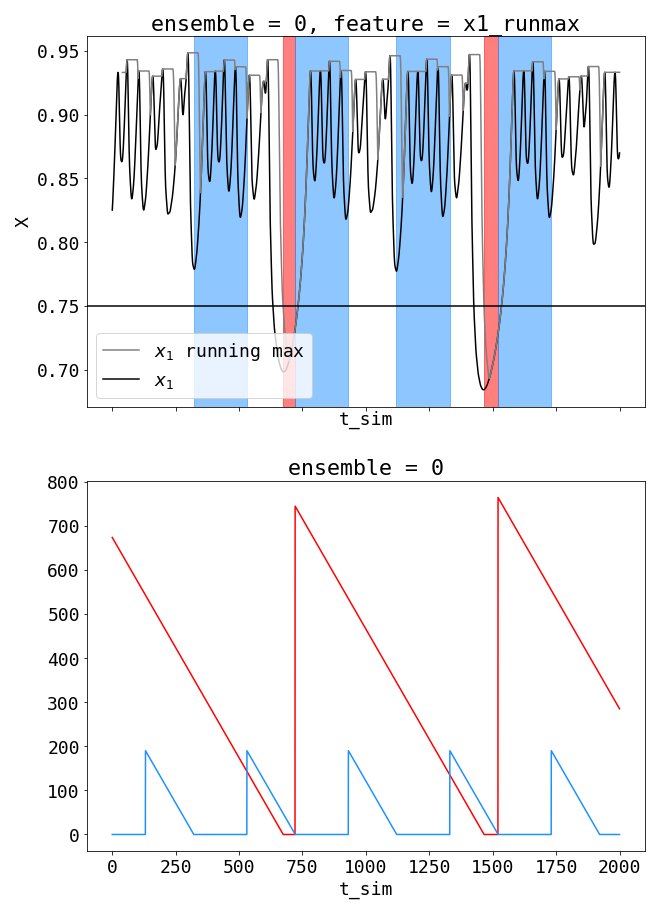

In [135]:
fig,axes = plt.subplots(nrows=2, figsize=(10,15), sharex=True)
sel = dict(member=0, t_sim=slice(None,2000))
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1"),
    color="black",ax=axes[0],label="$x_1$",x="t_sim"
)
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1_runmax"),
    color="gray",ax=axes[0],label="$x_1$ running max",x="t_sim")
# Find all the intervals in B
inb_starts = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["B"])) == 1)[0]
inb_ends = np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["B"])) == -1)[0]
print(f"Before snips, B: {len(inb_starts)} starts, {len(inb_ends)} ends")
if inb_starts[0] > inb_ends[0]: 
    inb_starts = inb_starts[1:]
if inb_starts[-1] > inb_ends[-1]:
    inb_starts = inb_starts[:-1]
print(f"After snips, B: {len(inb_starts)} starts, {len(inb_ends)} ends")
for i in range(len(inb_starts)):
    axes[0].axvspan(
        feat_tpt["ra"]["t_sim"][inb_starts[i]], feat_tpt["ra"]["t_sim"][inb_ends[i]], 
        color='red', alpha=0.5, zorder=-1
    )
ina_starts = np.sort(
    np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["A"])) == 1)[0])
ina_ends = np.sort(
    np.where(np.diff(1*(ab_tag["ra"].sel(sel,drop=True).data.flatten()==abcode["A"])) == -1)[0])
if ina_starts[0] > ina_ends[0]: 
    ina_ends = ina_ends[1:]
if ina_starts[-1] > ina_ends[-1]:
    ina_starts = ina_starts[:-1]
for i in range(len(ina_starts)):
    axes[0].axvspan(
        feat_tpt["ra"]["t_sim"][ina_starts[i]], feat_tpt["ra"]["t_sim"][ina_ends[i]], 
        color='dodgerblue', alpha=0.5, zorder=-1
    )    

axes[0].axhline(y=tpt_bndy["x1thresh"][0], color='black')
axes[0].legend(handles=[h_x1_runmax,h_x1])
h_tbp, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="B", sense="until", drop=True),
    ax=axes[1], label="$\tau_B^+$", color="red")
h_tap, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="A", sense="until", drop=True),
    ax=axes[1], label="$\tau_A^+$", color="dodgerblue")

In [136]:
print("ina_starts=", ina_starts)
print("ina_ends=", ina_ends)

ina_starts= [ 641 1441 2241 3041]
ina_ends= [1061 1861 2661 3461]


### Find and plot the committor, lead time, and current from reanalysis

In [137]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

shapes: field = (160000,), weights = (160000,), features = (160000, 1)
grid_cell: 
min = 
[0]
max=[19]
shapes: field = (160000,), weights = (160000,), features = (160000, 1)
grid_cell: 
min = 
[0]
max=[19]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Ex_11-02', ylabel='Committor to B'>)

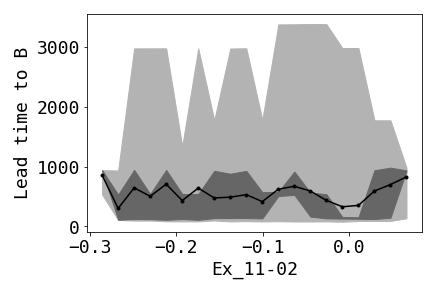

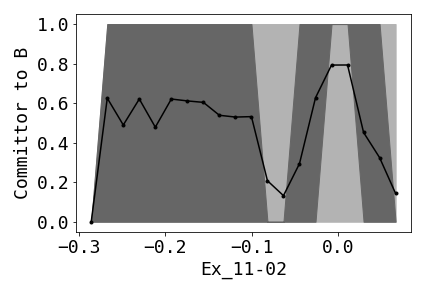

In [142]:
feat = "Ex_11-02"
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > tpt_bndy["tthresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < tpt_bndy["tthresh"][0]+10) 
)
helper2.plot_field_1d(
    sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)
helper2.plot_field_1d(
    comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1],
    feat_name=feat, field_name="Committor to B"
)

Choose two features for the space to plot

In [168]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

(<Figure size 1080x360 with 3 Axes>,
 <AxesSubplot:title={'center':'$-T_B^+$'}, xlabel='Ex_11-diss', ylabel='Ex_11-12'>)

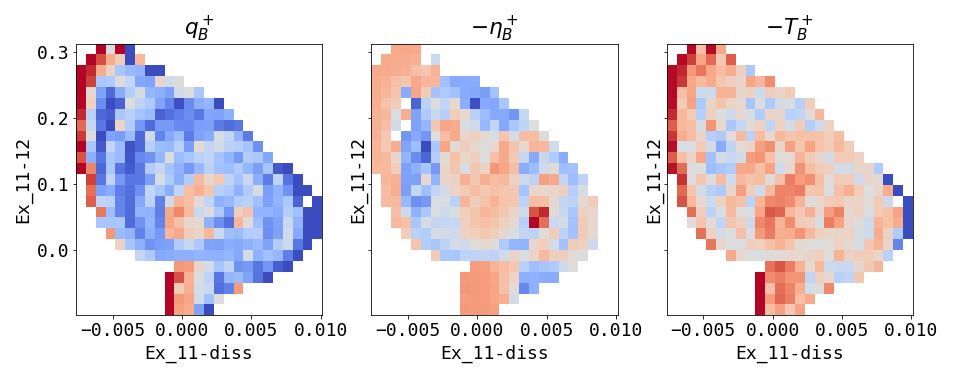

In [183]:
feat0,feat1 = "Ex_11-diss","Ex_11-12"
sel = dict(ensemble=0,member=0) 
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > tpt_bndy["tthresh"][0]) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < tpt_bndy["tthresh"][1]) 
)
qp = comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
Tb = sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten()

fig,axes = plt.subplots(ncols=3,figsize=(15,5), sharey=True, sharex=True)
helper2.plot_field_2d(
    qp,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[0], field_name="$q_B^+$"
)
helper2.plot_field_2d(
    -Tb*qp ,
    qp,
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[1], field_name="$-\eta_B^+$"
)
helper2.plot_field_2d(
    -Tb,
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).where(cond).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[25,25], fig=fig, ax=axes[2], field_name="$-T_B^+$"
)

# Markov State Modeling using hindcasts

The steps to building a MSM:
1. Select a set of features
2. Cluster the data *separately at each time of the season*
3. Count transitions from each box to each other box
4. Build a list of matrices

In [ ]:
msm_features = ["E_01","E_02","E_11","E_12","Ex_11-diss","Ex_11-12"]
feat_msm = dict()
for src in ["ra","hc"]:
    feat_msm[src] = feat_tpt[src].sel(feature=msm_features)
 

In [186]:
# Compute seasonal statistics
seasonal_stats = xr.DataArray(
    coords = {"t_szn_cent": crom_feat.t_szn_cent, "feature": msm_features},
    data = np.zeros((crom_feat.Nt_szn, len(msm_features))),
    dims = ["t_szn_cent", "feature"],
)
for feat in msm_features:
    
for src in ["ra","hc"]:
    data_vars = dict()
    for feat in msm_features:
        data_vars[feat] = helper2.project_field(
            feat_tpt[src]["X"].sel(feature=feat))
    feat_msm_szn_std[src] = xr.DataArray(
        data_vars=data_vars
    )

338

In [188]:
crom_feat.t_szn_cent.size

337